In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
from easydict import EasyDict
import yaml
from sklearn.model_selection import train_test_split
import os
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
from sklearn.preprocessing import LabelEncoder  
import librosa
import librosa.display
import cv2
import zipfile
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time
import copy
import IPython.display as ipd

import tensorflow_datasets as tfds

# Loading dataset

In [ ]:
# ds = tfds.load('vctk', 
#                split='train', 
#                shuffle_files=True, 
#                data_dir='/content/drive/MyDrive/НИС_2022/accent_recognition')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
!ls drive/MyDrive

accelerometer_data.csv	ml_lab3.ipynb		 ria_articles.json
big_data_course.ipynb	NIS_2022		 spark-2.4.8-bin-hadoop2.7.tgz
data_lab3		pandas_processing.ipynb  time_series_analysis.ipynb
kr_2022			ria_articles.csv	 Untitled


In [ ]:
%cd '/content/drive/MyDrive/NIS_2022/accent_recognition'

%pwd

%ls -a

/content/drive/MyDrive/NIS_2022/accent_recognition
downloads/  speaker-info.txt  txt/  vctk/


In [ ]:
!ls downloads

data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip
data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip.INFO
test_file.txt


In [ ]:
!du -sh data

11G	data


In [ ]:
!touch downloads/test_file.txt

In [ ]:
!ls downloads/

data
data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip
data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip.INFO
extracted
test_file.txt


In [ ]:
!unzip downloads/data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip -d data/

In [ ]:
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data2")
# zip_ref.close()

In [ ]:
!ls

speaker-info.txt  txt  update.txt  wav48_silence_trimmed


In [ ]:
speaker_info_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/speaker-info.txt'
speakers_dict = {}
accent_dict = {}
speakers = []
labels = []
with open(speaker_info_path) as f:
    line = f.readline()
    while line:
        line = f.readline()
        try:
          accent = line.split()[3]
          speaker = line.split()[0]
          if accent == 'Unknown' or accent == 'British' or accent == 'NewZealand' or accent == 'Welsh':
              continue
          if accent in speakers_dict:
              speakers_dict[accent] += 1
          else:
              speakers_dict[accent] = 1
              accent_dict[accent] = []
          accent_dict[accent].append(speaker)
          speakers.append(speaker)
          labels.append(accent)
        except:
          continue

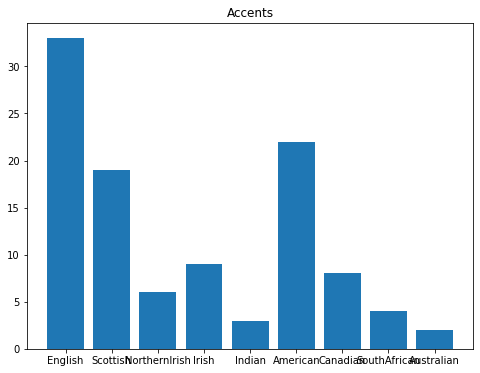

In [ ]:
keys = speakers_dict.keys()
values = speakers_dict.values()

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(keys, values)
plt.title('Accents')
plt.show()

In [ ]:
speakers_dict

{'American': 22,
 'Australian': 2,
 'Canadian': 8,
 'English': 33,
 'Indian': 3,
 'Irish': 9,
 'NorthernIrish': 6,
 'Scottish': 19,
 'SouthAfrican': 4}

In [ ]:
speakers_train = []
speakers_test = []
labels_train = []
labels_test = []

for key in accent_dict:
    labels_list = [key for _ in range(len(accent_dict[key]))]
    speakers_train_cur, speakers_test_cur, labels_train_cur, labels_test_cur = train_test_split(
        accent_dict[key], labels_list, test_size=0.2, random_state=42)
    
    speakers_train.extend(speakers_train_cur)
    speakers_test.extend(speakers_test_cur)
    labels_train.extend(labels_train_cur)
    labels_test.extend(labels_test_cur)

In [ ]:
# speakers_train, speakers_test, labels_train, labels_test = train_test_split(
#      speakers,  labels, test_size=0.2, random_state=42)

In [ ]:
# with open('/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data/config.yaml') as conf:
#     cfg = EasyDict(yaml.safe_load(conf))

# print(cfg)

{'clip_length': 5.0, 'sample_rate': 44100, 'hop_length': 441, 'n_fft': 1024, 'n_mels': 64, 'f_min': 0, 'f_max': 22050}


In [ ]:
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/'
speakers_train_paths = []
speakers_train_labels = []
count = 0
for speaker, label in zip(speakers_train, labels_train):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 200:
      files = files[:200]
    for file_name in files:
        if 'mic2' in file_name:
            continue
        speakers_train_paths.append(speaker_path + file_name)
        speakers_train_labels.append(label)


In [ ]:
speakers_test_paths = []
speakers_test_labels = []
count = 0
for speaker, label in zip(speakers_test, labels_test):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 200:
      files = files[:200]
    for file_name in files:
        if 'mic2' in file_name:
            continue
        speakers_test_paths.append(speaker_path + file_name)
        speakers_test_labels.append(label)

In [ ]:
def check_if_valid(speakers_paths, labels):
    new_speakers_paths = []
    new_labels = []
    for path, label in zip(speakers_paths, labels):
        try:
            sound, sample_rate = torchaudio.load(path)
            new_speakers_paths.append(path)
            new_labels.append(label)
        except:
            continue
    return new_speakers_paths, new_labels

In [ ]:
# speakers_train_paths, speakers_train_labels = check_if_valid(speakers_train_paths, speakers_train_labels)
# speakers_test_paths, speakers_test_labels = check_if_valid(speakers_test_paths, speakers_test_labels)

In [ ]:
speaker_set = set(speakers_train_labels)
number_of_unique_values = len(speaker_set)
print(speaker_set)

{'American', 'Scottish', 'Australian', 'SouthAfrican', 'NorthernIrish', 'English', 'Indian', 'Irish', 'Canadian'}


In [ ]:
speaker_set = set(speakers_test_labels)
number_of_unique_values = len(speaker_set)
print(speaker_set)

{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [ ]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

In [ ]:
len(speakers_train_labels)

8100

In [ ]:
len(speakers_train_paths)

4048

In [ ]:
le.inverse_transform(speakers_train_labels)

array(['English', 'English', 'English', ..., 'Australian', 'Australian',
       'Australian'], dtype='<U13')

# Data sample

In [ ]:
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/p225/p225_002_mic2.flac'

In [ ]:
sound, sample_rate = torchaudio.load(path)
ipd.Audio(data=sound[0,:],rate=sample_rate)

In [ ]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    path = os.fspath(file_path)
    wav,sr = librosa.load(path,sr=sr)
    # if wav.shape[0]<5*sr:
    #     wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    # else:
    #     wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db


def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled



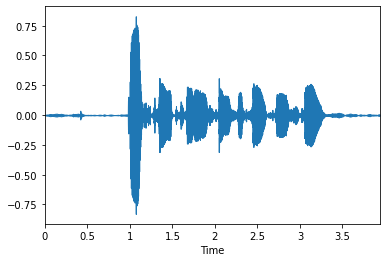

In [ ]:
y, sr = librosa.load(path)

whale_song, _ = librosa.effects.trim(y)
librosa.display.waveplot(whale_song, sr=sr);

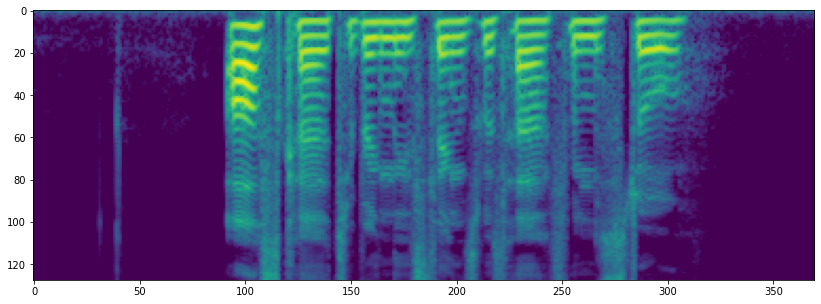

In [ ]:
melspectrogram = spec_to_image(get_melspectrogram_db(path))

plt.figure(figsize=(14, 8))
plt.imshow(melspectrogram)

In [ ]:
speakers_test_paths[0]

'/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/p286/p286_001_mic2.flac'

In [ ]:
test_data_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/validation/'
for speakers_test_path, speakers_test_label in zip(speakers_test_paths, 
                                                   le.inverse_transform(speakers_test_labels)):
    try:
        melspectrogram = spec_to_image(get_melspectrogram_db(speakers_test_path))
    except:
        continue
    img = Image.fromarray(melspectrogram)

    save_path = test_data_path+speakers_test_label
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img.save(save_path+'/'+os.path.splitext(os.path.basename(speakers_test_path))[0]+'.png')

In [ ]:
train_data_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/train/'
for speakers_train_path, speakers_train_label in zip(speakers_train_paths, 
                                                   le.inverse_transform(speakers_train_labels)):
    try:
        melspectrogram = spec_to_image(get_melspectrogram_db(speakers_train_path))
    except:
        continue
    img = Image.fromarray(melspectrogram)

    save_path = train_data_path+speakers_train_label
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img.save(save_path+'/'+os.path.splitext(os.path.basename(speakers_train_path))[0]+'.png')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
res = cv2.resize(melspectrogram, dsize=(128, 64), interpolation=cv2.INTER_CUBIC)

In [ ]:
melspectrogram.shape

(128, 370)

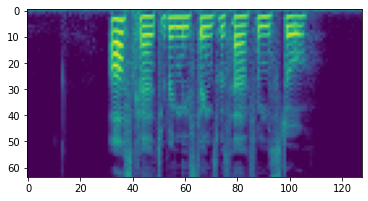

In [ ]:
plt.imshow(res)

In [ ]:
np.reshape(res, (1, 64, 128)).shape

(1, 64, 128)

# Format data

In [ ]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    # spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels
        # self.is_valid = is_valid
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        mel_specgram = spec_to_image(get_melspectrogram_db(filename))[np.newaxis,...]
        res = cv2.resize(mel_specgram[0, :, :], dsize=(128, 64), interpolation=cv2.INTER_CUBIC)
        return torch.tensor(np.reshape(res, (1, 64, 128)), dtype = torch.float), self.labels[index]

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

torch.Size([1, 64, 128])


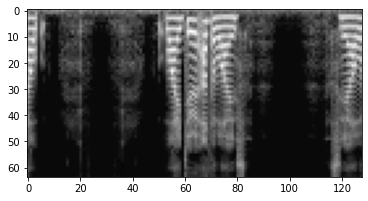

In [ ]:
def display_img(img,label):
    print(img.shape)
    plt.imshow(img[0, :, :], cmap='gray')

display_img(*train_dataset[4])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

# Define the Network

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class AccentClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(32768, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 9)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
model = AccentClassification()
model = model.to(device)

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func)

Epoch [0], train_loss: 2.2378, val_loss: 2.0071, val_acc: 0.2824
Epoch [1], train_loss: 1.8215, val_loss: 2.0329, val_acc: 0.2792
Epoch [2], train_loss: 1.7971, val_loss: 2.1318, val_acc: 0.2796
Epoch [3], train_loss: 1.7389, val_loss: 2.0397, val_acc: 0.2854
Epoch [4], train_loss: 1.6380, val_loss: 1.9884, val_acc: 0.2189


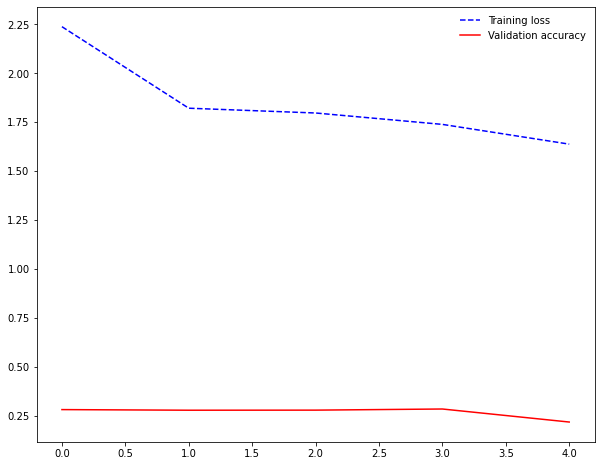

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.plot([x["train_loss"] for x in history], 'b--', label='Training loss')
plt.plot([x["val_acc"] for x in history], 'r', label='Validation accuracy')
# plt.plot([x["val_loss"] for x in history], 'b', label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [ ]:
confusion_matrix(y_labels_list, y_pred_list)

array([[250,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 50,   0,   0,   0,   0,   0,   0,   0,   0],
       [100,   0,   0,   0,   0,   0,   0,   0,   0],
       [350,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 50,   0,   0,   0,   0,   0,   0,   0,   0],
       [100,   0,   0,   0,   0,   0,   0,   0,   0],
       [100,   0,   0,   0,   0,   0,   0,   0,   0],
       [200,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 50,   0,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.20      1.00      0.33       250
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       350
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       200
           8       0.00      0.00      0.00        50

    accuracy                           0.20      1250
   macro avg       0.02      0.11      0.04      1250
weighted avg       0.04      0.20      0.07      1250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
le.classes_

array(['American', 'Australian', 'Canadian', 'English', 'Indian', 'Irish',
       'NorthernIrish', 'Scottish', 'SouthAfrican'], dtype='<U13')

# ResNet fine-tuning

In [ ]:
import torchvision.models as models

In [ ]:
input_size = 224
batch_size = 8

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'validation']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
num_classes = 9
num_epochs = 10

In [ ]:
resnet18_pretrained = models.resnet18(pretrained=True)
resnet18_pretrained.fc = nn.Linear(512, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# resnet18_pretrained = resnet18_pretrained.to(device)

params_to_update = resnet18_pretrained.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
criterion = nn.CrossEntropyLoss()
# Train and evaluate
resnet18_pretrained, hist = train_model(resnet18_pretrained,
                             dataloaders_dict,
                             criterion, optimizer_ft, 
                             num_epochs=num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.7101 Acc: 0.3714
validation Loss: 2.2186 Acc: 0.2903

Epoch 1/9
----------
train Loss: 1.4081 Acc: 0.4799
validation Loss: 2.5225 Acc: 0.3328

Epoch 2/9
----------
train Loss: 1.1911 Acc: 0.5610
validation Loss: 2.9830 Acc: 0.3208

Epoch 3/9
----------
train Loss: 1.1033 Acc: 0.5983
validation Loss: 3.0305 Acc: 0.3468

Epoch 4/9
----------
train Loss: 1.0115 Acc: 0.6357
validation Loss: 3.8414 Acc: 0.2367

Epoch 5/9
----------
train Loss: 0.9227 Acc: 0.6651
validation Loss: 4.2247 Acc: 0.3096

Epoch 6/9
----------
train Loss: 0.8366 Acc: 0.6945
validation Loss: 4.3591 Acc: 0.3720

Epoch 7/9
----------
train Loss: 0.8212 Acc: 0.7029
validation Loss: 4.1822 Acc: 0.3272

Epoch 8/9
----------
train Loss: 0.7619 Acc: 0.7222
validation Loss: 4.3345 Acc: 0.3144

Epoch 9/9
----------
train Loss: 0.7484 Acc: 0.7306
validation Loss: 4.4424 Acc: 0.3320

Training complete in 372m 27s
Best val Acc: 0.372046


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
resnet18_pretrained.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        # images, _ = images.cuda(), labels.cuda()
        y_test_pred = resnet18_pretrained(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.19      0.93      0.31       501
           1       0.14      0.06      0.08       100
           2       0.00      0.00      0.00       201
           3       0.00      0.00      0.00       696
           4       0.00      0.00      0.00       101
           5       0.00      0.00      0.00       201
           6       0.00      0.00      0.00       200
           7       0.00      0.00      0.00       397
           8       0.00      0.00      0.00       100

    accuracy                           0.19      2497
   macro avg       0.04      0.11      0.04      2497
weighted avg       0.04      0.19      0.07      2497



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix(y_labels_list, y_pred_list)

array([[465,  36,   0,   0,   0,   0,   0,   0,   0],
       [ 94,   6,   0,   0,   0,   0,   0,   0,   0],
       [201,   0,   0,   0,   0,   0,   0,   0,   0],
       [696,   0,   0,   0,   0,   0,   0,   0,   0],
       [101,   0,   0,   0,   0,   0,   0,   0,   0],
       [201,   0,   0,   0,   0,   0,   0,   0,   0],
       [200,   0,   0,   0,   0,   0,   0,   0,   0],
       [395,   2,   0,   0,   0,   0,   0,   0,   0],
       [100,   0,   0,   0,   0,   0,   0,   0,   0]])